In [17]:
import re
import torch
import sympy
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from mpl_toolkits.mplot3d import Axes3D
# from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

In [18]:
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "gray"}
sns.set_style("darkgrid", rc = custom)

## $\text {Importing data}$

In [31]:
path = '/content/Data_1.csv'
data = pd.read_csv(path, encoding='cp1251', sep=';')
data

<ipython-input-31-05d4373719cd>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path, encoding='cp1251', sep=';')


,Time,Height,Speed,Theta,Xi,Phi,Lambda,Radius,x_gpsk,y_gpsk,...,w_z_gpsk,x_mzsk,y_mzsk,z_mzsk,v_x_mzsk,v_y_mzsk,v_z_mzsk,w_x_mzsk,w_y_mzsk,w_z_mzsk
0,0.0,0.000000,10.000000,1.047198,1.570796,0.000000e+00,0.000000e+00,6.378182e+06,6.378137e+06,0.000000e+00,...,66.758728,0.000000e+00,0.000000,0.000000,3.061596e-16,8.660254,4.966493,-0.000799,110.257156,66.758728
1,0.01,0.086603,12.581952,1.042308,1.570799,7.839225e-09,4.800141e-25,6.378182e+06,6.378137e+06,3.061596e-18,...,100.363896,3.061596e-18,0.086603,0.049665,-7.988544e-06,9.762826,5.634081,-0.001363,165.252874,100.363896
2,0.02,0.195257,15.164135,1.038388,1.570801,1.778592e-08,-2.504977e-14,6.378182e+06,6.378137e+06,-1.597709e-07,...,134.382662,-1.597709e-07,0.195257,0.112682,-2.726516e-05,11.965312,6.973771,-0.002258,220.004101,134.382662
3,0.03,0.325909,17.746501,1.035115,1.570804,2.985434e-08,-8.549569e-14,6.378182e+06,6.378137e+06,-5.453033e-07,...,135.144857,-5.453033e-07,0.325909,0.189140,-5.313873e-05,14.162908,8.321734,-0.002917,219.551558,135.144857
4,0.04,0.478515,20.329018,1.032302,1.570806,4.405634e-08,-1.916775e-13,6.378182e+06,6.378137e+06,-1.222546e-06,...,135.794882,-1.222546e-06,0.478515,0.279116,-8.560460e-05,16.356343,9.676668,-0.003576,219.162123,135.794882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91993,919.93,2.887628,297.998237,-0.210617,1.562046,8.148877e-02,-2.719766e-04,6.378042e+06,6.357116e+06,-1.728987e+03,...,0.883233,-1.728987e+03,-21021.406765,515707.643139,2.564811e+00,-85.491900,283.451670,0.021231,-1.043882,0.883233
91994,919.94,2.266217,298.009768,-0.210641,1.562045,8.148923e-02,-2.719726e-04,6.378042e+06,6.357115e+06,-1.728961e+03,...,0.883600,-1.728961e+03,-21022.261737,515710.477700,2.565024e+00,-85.502335,283.460505,0.021236,-1.043135,0.883600
91995,919.95,1.644710,298.021302,-0.210666,1.562045,8.148968e-02,-2.719686e-04,6.378041e+06,6.357114e+06,-1.728936e+03,...,0.883967,-1.728936e+03,-21023.116812,515713.312349,2.565236e+00,-85.512762,283.469342,0.021240,-1.042385,0.883967
91996,919.96,1.023108,298.032836,-0.210690,1.562044,8.149014e-02,-2.719646e-04,6.378040e+06,6.357113e+06,-1.728910e+03,...,0.663158,-1.728910e+03,-21023.971992,515716.147086,2.565448e+00,-85.523182,283.478184,0.015932,-0.781415,0.663158


### $\text {Take only 4 columns that we need}$

In [32]:
new_mzsk_coords = data[['Time', 'x_mzsk', 'y_mzsk', 'z_mzsk']].copy()
new_mzsk_coords

,Time,x_mzsk,y_mzsk,z_mzsk
0,0.0,0.000000e+00,0.000000,0.000000
1,0.01,3.061596e-18,0.086603,0.049665
2,0.02,-1.597709e-07,0.195257,0.112682
3,0.03,-5.453033e-07,0.325909,0.189140
4,0.04,-1.222546e-06,0.478515,0.279116
...,...,...,...,...
91993,919.93,-1.728987e+03,-21021.406765,515707.643139
91994,919.94,-1.728961e+03,-21022.261737,515710.477700
91995,919.95,-1.728936e+03,-21023.116812,515713.312349
91996,919.96,-1.728910e+03,-21023.971992,515716.147086


### $\text {Let`s trim our data to ger the correct values}$

In [33]:
new_mzsk_coords = new_mzsk_coords.iloc[300:, :]
new_mzsk_coords

,Time,x_mzsk,y_mzsk,z_mzsk
300,2.99999999999998,-0.292588,975.534486,667.187240
301,3.00999999999998,-0.295490,981.899807,671.643442
302,3.0199999999999796,-0.298411,988.285180,676.114564
303,3.0299999999999794,-0.301351,994.690594,680.600605
304,3.039999999999979,-0.304310,1001.116037,685.101566
...,...,...,...,...
91993,919.93,-1728.986808,-21021.406765,515707.643139
91994,919.94,-1728.961159,-21022.261737,515710.477700
91995,919.95,-1728.935508,-21023.116812,515713.312349
91996,919.96,-1728.909854,-21023.971992,515716.147086


### $\text {We need to check our data and correct errors because some values in 'Time' are incorrect}$

In [34]:
def str_to_float(x):
    try:
        return float(x)
    except ValueError:
        return None

new_mzsk_coords.loc[:, 'Time'] = new_mzsk_coords['Time'].apply(lambda x: str_to_float(x))
new_mzsk_coords = new_mzsk_coords.dropna(subset=['Time'])

# Либо же другой способ

# mzsk_coords['Time'] = pd.to_numeric(mzsk_coords.Time, errors='coerce')
# mzsk_coords = mzsk_coords.dropna(subset=['Time'])

### $\text {This filter works with nonlinear problems}$
### $\text {The EKF does not alter the Kalman filter's linear equations. Instead, it *linearizes*}$
### $\text {the nonlinear equations at
the point of the current estimate, and uses this linearization in the linear Kalman filter}$

### $\text {This is the main idea of this filter}$

$$
\begin{aligned}
\mathbf F
&= {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf H &= \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}
\end{aligned}
$$

### $\text {Algorithm of the EKF:}$

$$\begin{array}{l|l}
\text{linear Kalman filter} & \text{EKF} \\
\hline
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$


### $\text {In this case I will initialize the filter state in MZSK, and the measurments will be in ABSK}$

### $\text {I need 2 functions that will translate coordinates form MZSK to ABSK and back}$

In [35]:
# Only in this case I swap values of 'y_mzsk' and 'z_mzsk' since it
new_mzsk_coords.loc[:, ['y_mzsk', 'z_mzsk']] = \
    new_mzsk_coords[['z_mzsk', 'y_mzsk']].values

In [36]:
new_mzsk_coords

,Time,x_mzsk,y_mzsk,z_mzsk
300,3.0,-0.292588,667.187240,975.534486
301,3.01,-0.295490,671.643442,981.899807
302,3.02,-0.298411,676.114564,988.285180
303,3.03,-0.301351,680.600605,994.690594
304,3.04,-0.304310,685.101566,1001.116037
...,...,...,...,...
91993,919.93,-1728.986808,515707.643139,-21021.406765
91994,919.94,-1728.961159,515710.477700,-21022.261737
91995,919.95,-1728.935508,515713.312349,-21023.116812
91996,919.96,-1728.909854,515716.147086,-21023.971992


## $\text {For 3-dimensional case}$

### $\text {State of filter: [x, y, z]}$
### $\text {Measurments: [R, u, v]}$

In [73]:
def find_R(value_columns, A, r0):
    # x, y, z = value_columns
    r = np.array(value_columns)

    # Расчет наклонной дальности
    R = np.sqrt(np.sum(r**2) + 2 * np.dot(A @ r, r0))

    return R.item()

def find_v(value_columns, A, r0):

    r = np.array(value_columns)

    #
    v = (A @ r)[2] / np.sqrt(np.sum(r**2) + 2 * np.dot(A @ r, r0))

    return v.item()

def find_u(value_columns, A, r0):

    r = np.array(value_columns)

    u = (A @ r)[0] / np.sqrt(np.sum(r**2) + 2 * np.dot(A @ r, r0))

    return u.item()

def mzsk_to_absk(value_columns):
    # Матрица поворота
    A = np.eye(3, 3)

    # Вектор начало АБСК в МЗСПК
    r0 = np.zeros((3, 1))
    # print(f'value_columns = {value_columns}')

    R = find_R(value_columns, A, r0)
    v = find_v(value_columns, A, r0)
    u = find_u(value_columns, A, r0)

    return np.array([R, u, v])

In [78]:
new_mzsk_coords[['R', 'u', 'v']] = new_mzsk_coords[
    ['x_mzsk', 'y_mzsk', 'z_mzsk']
].apply(
    lambda x: mzsk_to_absk(x),
    axis=1,
    result_type='expand'
)

<ipython-input-78-1fa611325894>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_mzsk_coords[['R', 'u', 'v']] = new_mzsk_coords[


In [79]:
new_mzsk_coords

,Time,x_mzsk,y_mzsk,z_mzsk,R,u,v
300,3.0,-0.292588,667.187240,975.534486,1181.865657,-0.000248,0.825419
301,3.01,-0.295490,671.643442,981.899807,1189.635336,-0.000248,0.825379
302,3.02,-0.298411,676.114564,988.285180,1197.429994,-0.000249,0.825339
303,3.03,-0.301351,680.600605,994.690594,1205.249622,-0.000250,0.825298
304,3.04,-0.304310,685.101566,1001.116037,1213.094212,-0.000251,0.825258
...,...,...,...,...,...,...,...
91993,919.93,-1728.986808,515707.643139,-21021.406765,516138.801225,-0.003350,-0.040728
91994,919.94,-1728.961159,515710.477700,-21022.261737,516141.668154,-0.003350,-0.040730
91995,919.95,-1728.935508,515713.312349,-21023.116812,516144.535176,-0.003350,-0.040731
91996,919.96,-1728.909854,515716.147086,-21023.971992,516147.402293,-0.003350,-0.040732


### $\text {For this filter we need to find Jacobian}$
### $\text {In my case I can use sympy library for finding Jacobian}$

In [80]:
sympy.init_printing(use_latex='mathjax')
x, y, z = sympy.symbols('x, y, z')

H = sympy.Matrix([[sympy.sqrt(x**2 + y**2 + z**2)],
                  [x / sympy.sqrt(x**2 + y**2 + z**2)],
                  [z / sympy.sqrt(x**2 + y**2 + z**2)]])

state = sympy.Matrix([x, y, z])

J = H.jacobian(state)
J

⎡                   x                             y                             z                  ↪
⎢           ─────────────────             ─────────────────             ─────────────────          ↪
⎢              ______________                ______________                ______________          ↪
⎢             ╱  2    2    2                ╱  2    2    2                ╱  2    2    2           ↪
⎢           ╲╱  x  + y  + z               ╲╱  x  + y  + z               ╲╱  x  + y  + z            ↪
⎢                                                                                                  ↪
⎢          2                                                                                       ↪
⎢         x                    1                -x⋅y                          -x⋅z                 ↪
⎢- ───────────────── + ─────────────────  ─────────────────             ─────────────────          ↪
⎢                3/2      ______________                3/2                           3/2  

### $\text {Filter structure}$

In [82]:
class EKF_filter():
    def __init__(self, x_start, P, Q, R, F):
        self.x = x_start.to(dtype=torch.float64)
        self.P = P.to(dtype=torch.float64)
        self.Q = Q.to(dtype=torch.float64)
        self.R = R.to(dtype=torch.float64)
        self.F = F.to(dtype=torch.float64)

    def h(self, x):
        # print(f'Состояние в функции h = {x}')
        R = torch.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
        # print(f'R в функции h = {R}')
        u = x[0] / R
        # print(f'Угол u в функции h = {u}')
        v = x[2] / R
        # print(f'Угол v в функции h = {v}')
        return torch.tensor([R, u, v], dtype=torch.float64).view(-1, 1)

    def H_jacobian(self, x):
        R = torch.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
        R3 = (R**3).item()
        H = torch.tensor([
            [x[0] / R.item(), x[1] / R.item(), x[2] / R.item()],
            [-x[0]**2 / R3 + 1 / R.item(), -x[0]*x[1] / R3, -x[0]*x[2] / R3],
            [-(x[0] * x[2]) / R3, -x[1]*x[2] / R3,-x[2]**2 / R3 + 1 / R.item()]
        ], dtype=torch.float64)

        return H

    def predict(self):

        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

        return self.x, self.P

    def update(self, measurement):

        H = self.H_jacobian(self.x)
        residual = measurement.to(torch.float64) - self.h(self.x)
        # print(f'Невязка равна = {residual}')

        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ torch.inverse(S)

        self.x = self.x + K @ residual
        I = torch.eye(3, dtype=torch.float64)
        self.P = (I - K @ H) @ self.P

        # print(f'x_est = {x_est}')

        return self.x, self.P, residual

### $\text {Filter parameters}$

In [85]:
P_ekf = torch.eye(3) * 50
Q_ekf = torch.tensor([[0.01, 0., 0.],
                      [0., 0.01, 0.],
                      [0., 0., 0.01]])

R_ekf = torch.tensor([
    [10e-10, 0., 0.],
    [0., 10e-10, 0.],
    [0., 0., 10e-10]])

F_ekf = torch.eye(3)
x_start = torch.tensor([new_mzsk_coords.x_mzsk.iloc[0],
                        new_mzsk_coords.y_mzsk.iloc[0],
                        new_mzsk_coords.z_mzsk.iloc[0]]).reshape(-1, 1)

residuals = torch.tensor([0, 0, 0])

In [86]:
ekf = EKF_filter(x_start, P_ekf, Q_ekf, R_ekf, F_ekf)

In [87]:
trajectory_ekf = x_start.clone().detach().view(-1)
trajectory_ekf

tensor([-2.9259e-01,  6.6719e+02,  9.7553e+02], dtype=torch.float64)

### $\text {Filtering process}$

In [89]:
for i in range(0, len(new_mzsk_coords.x_mzsk)-1):     # len(new_mzsk_coords.x_mzsk)

    measurment = torch.tensor([new_mzsk_coords.R.iloc[i],
                               new_mzsk_coords.u.iloc[i],
                               new_mzsk_coords.v.iloc[i]]).view(-1, 1)
    # print(f'measurment = {measurment}')

    x_pred, P_pred = ekf.predict()
    # print(P_pred)
    x_est, P_est, residual = ekf.update(measurment)
    # print(f'residual = {residual}')
    # print(x_est.T, x_est.T.shape)
    # print(P_est)
    trajectory_ekf = torch.vstack([trajectory_ekf, x_est.view(-1)])
    residuals = torch.vstack([residuals, residual.view(-1)])

### $\text {Let`s see the work of EKF and compare predictions with ortiginal data}$

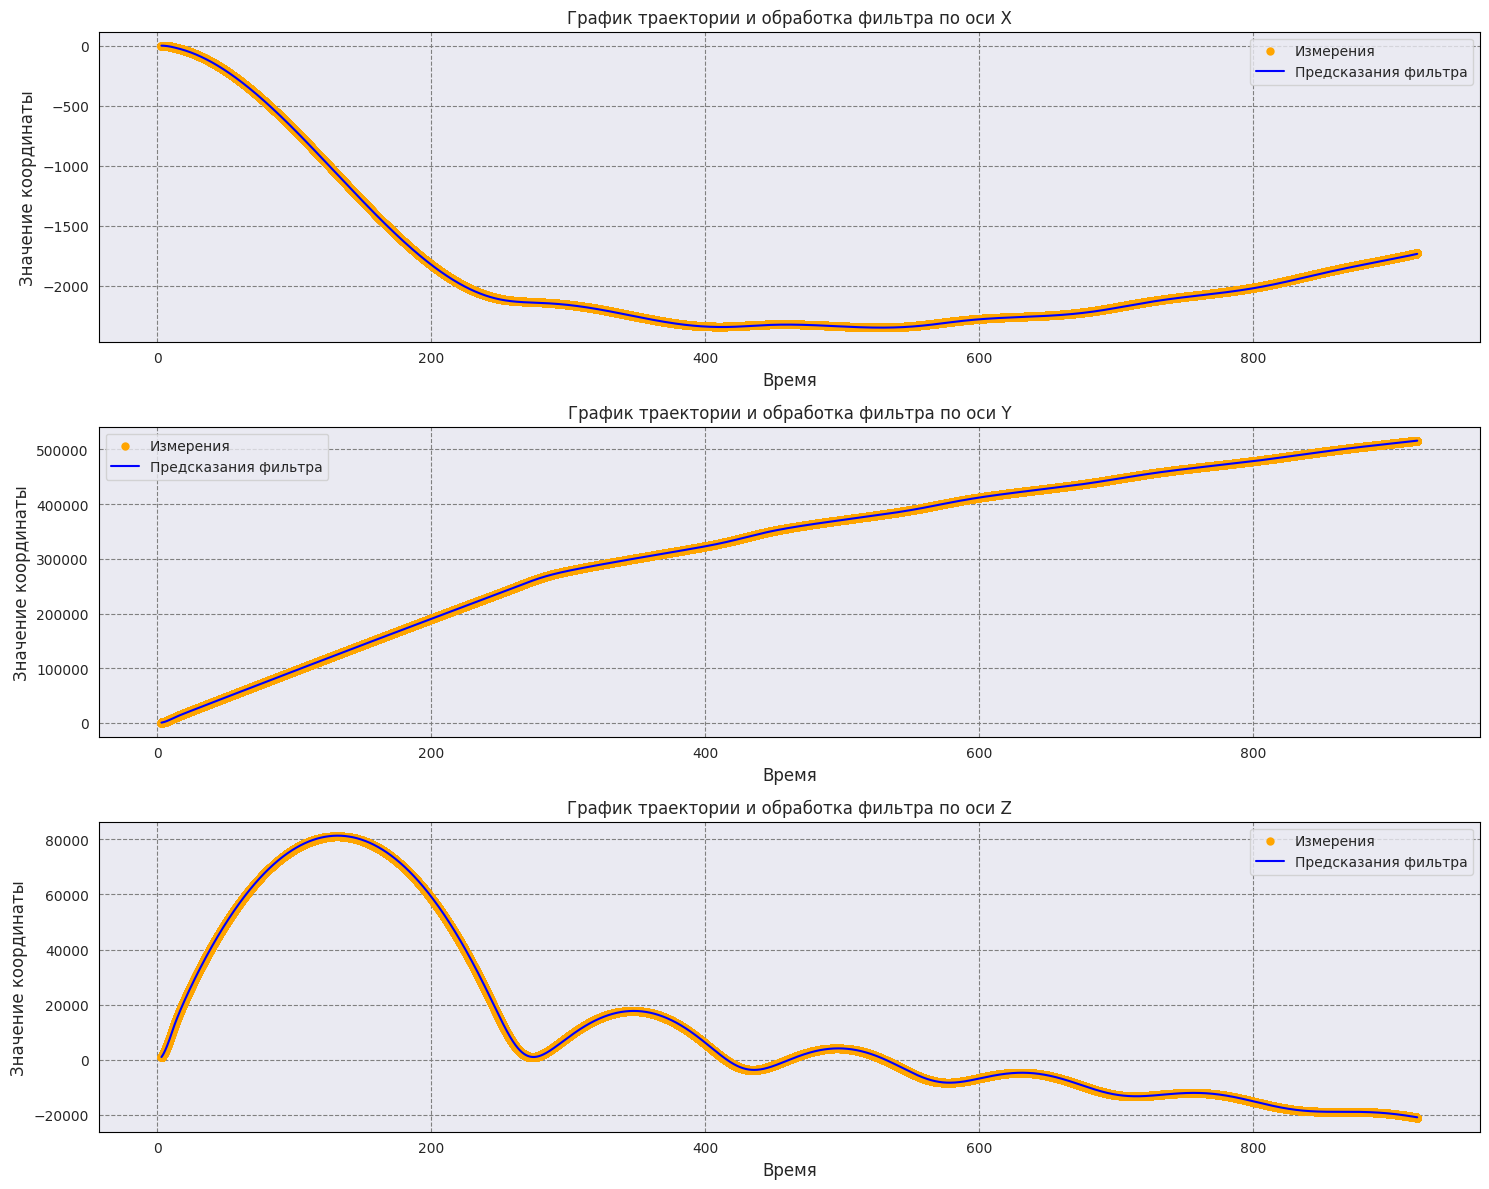

In [102]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12))

ax[0].scatter(new_mzsk_coords.Time,
              new_mzsk_coords.x_mzsk,
              label = 'Измерения',
              color='orange',
              linewidths=0.01)
ax[0].plot(new_mzsk_coords.Time,
           trajectory_ekf[:, 0],
           label='Предсказания фильтра',
           color='blue')
ax[0].grid(True)
ax[0].set_title('График траектории и обработка фильтра по оси Х')
ax[0].set_xlabel('Время', size=12)
ax[0].set_ylabel('Значение координаты', size=12)
ax[0].legend()

ax[1].scatter(new_mzsk_coords.Time,
              new_mzsk_coords.y_mzsk,
              label = 'Измерения',
              color='orange',
              linewidths=0.01)
ax[1].plot(new_mzsk_coords.Time,
              trajectory_ekf[:, 1],
              label='Предсказания фильтра',
              color='blue')
ax[1].grid(True)
ax[1].set_title('График траектории и обработка фильтра по оси Y')
ax[1].set_xlabel('Время', size=12)
ax[1].set_ylabel('Значение координаты', size=12)
ax[1].legend()

ax[2].scatter(new_mzsk_coords.Time,
              new_mzsk_coords.z_mzsk,
              label = 'Измерения',
              color='orange',
              linewidths=0.01)
ax[2].plot(new_mzsk_coords.Time,
              trajectory_ekf[:, 2],
              label='Предсказания фильтра',
              color='blue')
ax[2].grid(True)
ax[2].set_title('График траектории и обработка фильтра по оси Z')
ax[2].set_xlabel('Время', size=12)
ax[2].set_ylabel('Значение координаты', size=12)
ax[2].legend()

plt.tight_layout()
plt.show()

### $\text {Residuals - the main indicator of filter performance}$
### $\text{Let`s see, how EKF works with this trajectory}$

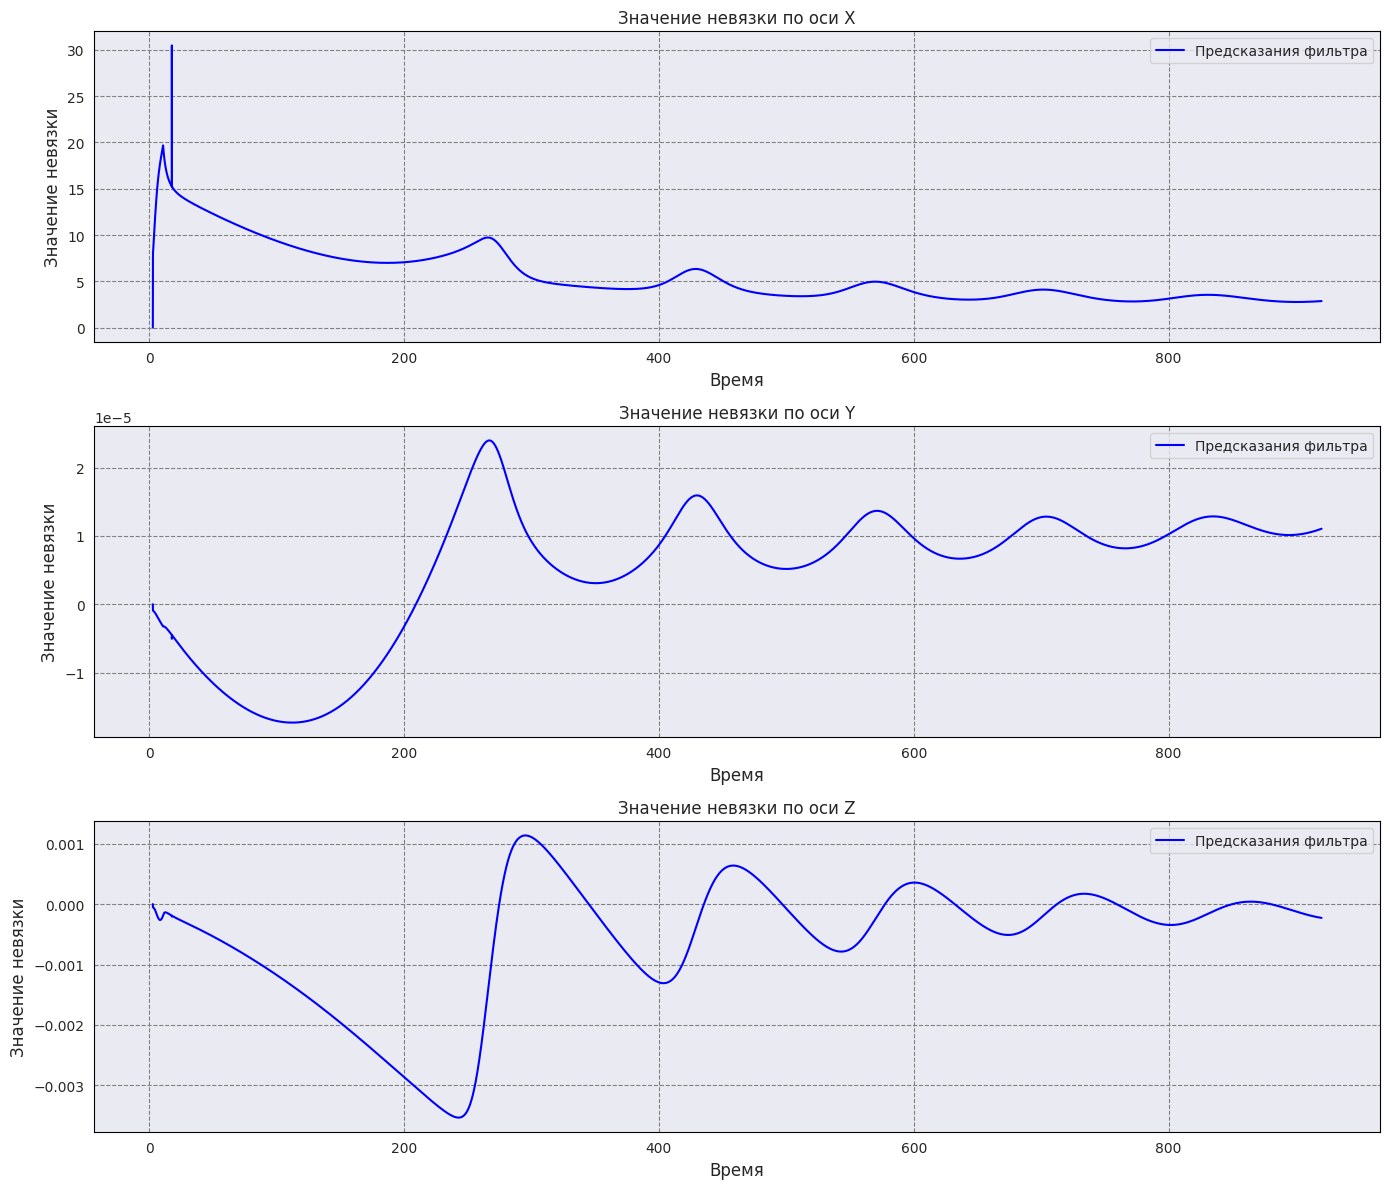

In [106]:
fig, ax = plt.subplots(3, 1, figsize=(14, 12))

ax[0].plot(new_mzsk_coords.Time,
           residuals[:, 0],
           label='Предсказания фильтра',
           color='blue')

ax[0].grid(True)
ax[0].set_title('Значение невязки по оси X')
ax[0].set_xlabel('Время', size=12)
ax[0].set_ylabel('Значение невязки', size=12)
ax[0].legend()

ax[1].plot(new_mzsk_coords.Time,
           residuals[:, 1],
           label='Предсказания фильтра',
           color='blue')

ax[1].grid(True)
ax[1].set_title('Значение невязки по оси Y')
ax[1].set_xlabel('Время', size=12)
ax[1].set_ylabel('Значение невязки', size=12)
ax[1].legend()

ax[2].plot(new_mzsk_coords.Time,
           residuals[:, 2],
           label='Предсказания фильтра',
           color='blue')

ax[2].grid(True)
ax[2].set_title('Значение невязки по оси Z')
ax[2].set_xlabel('Время', size=12)
ax[2].set_ylabel('Значение невязки', size=12)
ax[2].legend()

plt.tight_layout()
plt.show()

## $\text {Conclusions:}$

### $\text {1) First of all EKF is one of the best algorithm for nonlinear problems}$

### $\text {2) Comparing this results with standart multidimensional Kalman Filter, we can see}$
### $\text {that maximum deviations are much smaller for EKF}$

### $\text {3) However, the sigma-points filter (UKF) due to its more complex structure wins over the EKF in some situations}$